In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage.measure import block_reduce

### Define Hyperparameters

In [21]:
batch_size = 4
n_classes = 5

### Define Computation Graph

In [22]:
def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))


def scale_and_shift_flat(x, labels, name='s_and_s'):
    with tf.variable_scope(name, reuse=None):
        axis = [1]
        x_shape = x.get_shape().as_list()
        beta = tf.get_variable( 'beta', [n_classes])
        gamma = tf.get_variable( 'gamma', [n_classes])

        class_shift = tf.gather(beta, labels)
        class_shift = tf.expand_dims(class_shift, 1)

        class_scale = tf.gather(gamma, labels)
        class_scale = tf.expand_dims(class_scale, 1)

        variance_epsilon = 0.01
        mean, variance = tf.nn.moments(x, axis, keep_dims=True)
        output = tf.nn.batch_normalization(x=x, mean=mean,
                                           variance=variance,
                                           offset=class_shift, scale=class_scale,
                                           variance_epsilon=variance_epsilon)
        return output
        

def scale_and_shift(x, labels, name='s_and_s'):
    with tf.variable_scope(name, reuse=None):
        axis = [1,2]
        x_shape = x.get_shape().as_list()
        beta = tf.get_variable( 'beta', [n_classes])
        gamma = tf.get_variable( 'gamma', [n_classes])
        
        class_shift = tf.gather(beta, labels)
        class_shift = tf.expand_dims(tf.expand_dims(tf.expand_dims(class_shift, 1), 1), 1)
        
        class_scale = tf.gather(gamma, labels)
        class_scale = tf.expand_dims(tf.expand_dims(tf.expand_dims(class_scale, 1), 1), 1)
        
        variance_epsilon = 0.01
        mean, variance = tf.nn.moments(x, axis, keep_dims=True)
        output = tf.nn.batch_normalization(x=x, mean=mean,
                                           variance=variance,
                                           offset=class_shift, scale=class_scale,
                                           variance_epsilon=variance_epsilon)
        return output

    
def encoder(X_in, labels, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 210, 160, 3])
        
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = scale_and_shift(x, labels, name='s_and_s/1')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = scale_and_shift(x, labels, name='s_and_s/2')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = scale_and_shift(x, labels, name='s_and_s/3')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        return z, mn, sd


def decoder(sampled_z, labels, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = scale_and_shift_flat(x, labels, name='s_and_s/4')
        
        x = tf.layers.dense(x, units=(inputs_decoder * 2 + 1), activation=lrelu)
        x = scale_and_shift_flat(x, labels, name='s_and_s/5')
        x = tf.reshape(x, reshaped_dim)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels, name='s_and_s/6')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels, name='s_and_s/7')
        x = tf.nn.dropout(x, keep_prob)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = scale_and_shift(x, labels, name='s_and_s/8')
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=210*160*3, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 210, 160, 3])
        return img

### Initialize Computation Graph

In [23]:
tf.reset_default_graph()

batch_size = 4
n_classes = 10

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 70, 54, 3], name='X')
Labels = tf.placeholder(dtype=tf.int32, shape=[None], name='Labels')
Y = tf.placeholder(dtype=tf.float32, shape=[None, 70, 54, 3], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 70*54*3])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2

sampled, mn, sd = encoder(X_in, Labels, keep_prob)
dec = decoder(sampled, Labels, keep_prob)

unreshaped = tf.reshape(dec, [-1, 70*54*3])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)

# introduce variable learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.0005
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
print('Starting session...')
sess = tf.Session()
print('Initializing variables...')
sess.run(tf.global_variables_initializer())
print('Variables initialized.')

Starting session...
Initializing variables...
Variables initialized.


### Gather New Training Data

In [5]:
directories = ['jamesbond', 'spaceinvaders', 'tutankham', 'venture', 'zaxxon']
state_label_pairs = []
for i, root_dir in enumerate(directories):
    for dir_name, subdir_list, file_list in os.walk(root_dir+'/'):
        for fname in file_list:
            state_label_pairs.append((root_dir + '/' + fname, i))

print('Found {} files.'.format(len(state_label_pairs)))

Found 500 files.


### Train the Model

(210, 160, 3)
	 (210, 160, 3)
		 (70, 54, 3)


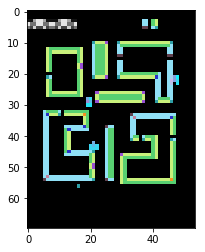

(250, 160, 3)
	 (210, 160, 3)
		 (70, 54, 3)


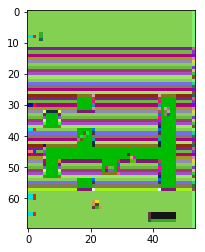

(210, 160, 3)
	 (210, 160, 3)
		 (70, 54, 3)


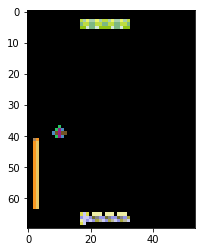

(210, 160, 3)
	 (210, 160, 3)
		 (70, 54, 3)


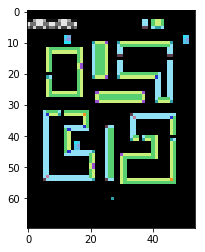

In [24]:
def reduce_image_shape(image):
    height = image.shape[0] - 210
    change = height // 2
    cut_image = image[change:(change+210),:]
    return cut_image
    
def downsample_image(image):
    red_image = block_reduce(image, block_size=(3, 3, 1), func=np.mean)
    return red_image

def read_image(filename):
    image = np.load(filename)
    print(image.shape)
    cut_image = reduce_image_shape(image)
    print('\t', cut_image.shape)
    red_image = downsample_image(cut_image)
    print('\t\t', red_image.shape)
    plt.imshow(red_image)
    plt.show()
    return red_image


batch_losses = []
avg_img_losses = []
sparse_batch_losses = []

for i in range(1):
    next_batch = random.sample(state_label_pairs, batch_size)
    batch = [read_image(b[0]) for b in next_batch]
    labels = [lab[1] for lab in next_batch]
    break
    batch_loss, batch_img_loss, _ = sess.run([loss, img_loss, optimizer], feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 0.8})
    batch_losses.append(batch_loss)
    avg_img_losses.append(np.mean(batch_img_loss))
        
    if not i % 200:
        batch_loss, decoded, batch_img_loss, mu, sigm = sess.run([loss, dec, img_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, Labels: labels, keep_prob: 1.0})
        batch_losses.append(batch_loss)
        sparse_batch_losses.append(batch_loss)
        avg_img_losses.append(np.mean(batch_img_loss))
        
        plt.imsave(fname='multi_vae_results/iteration_{}_original.png'.format(i), arr=np.reshape(batch[0], [210, 160, 3]), format='png')
        plt.imsave(fname='multi_vae_results/iteration_{}_reconstructed.png'.format(i), arr=decoded[0], format='png')
        
        # plt.title('Batch losses')
        # plt.plot(np.arange(len(batch_losses)), batch_losses)
        # plt.tight_layout()
        # plt.savefig('multi_vae_results/iteration_{}_batch_losses', dpi=300)
        
        # plt.title('Sparse Batch losses')
        # plt.plot(np.arange(len(sparse_batch_losses)), sparse_batch_losses)
        # plt.tight_layout()
        # plt.savefig('multi_vae_results/iteration_{}_sparse_batch_losses', dpi=300)
        
        print('iteration: {}; batch loss: {}, mean img loss: {}'.format(i, batch_loss, np.mean(batch_img_loss)))

np.save(file='all_batch_losses', arr=batch_losses)
np.save(file='sparse_batch_losses', arr=sparse_batch_losses)

### Sample New Images

In [ ]:
n_samples = 10
randoms = [np.random.normal(0, 1, n_latent) for _ in range(n_samples)]
classes = [np.random.choice(n_classes) for _ in range(n_samples)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [210, 160, 3]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img)
    
n_samples = 10
randoms = [np.random.normal(0, 1, n_latent) for _ in range(n_samples)]
labels = [np.random.choice(n_classes) for _ in range(n_samples)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, Labels: labels, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [210, 160, 3]) for i in range(len(imgs))]

for i, img, c in zip(range(n_samples, imgs, classes)):
    plt.imsave(fname='multi_vae_results/reconstruction_{}_class_{}'.format(i, c), arr=img, format='png')